# Assignment 1. Deep Learning Fundamentals

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import product

from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch.optim as optim

import warnings
warnings.filterwarnings("ignore")  # Suppress all warnings

## 1. Load data

In [2]:
df = pd.read_csv('diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## 2. Exploratory Data Analysis

In [3]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [4]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

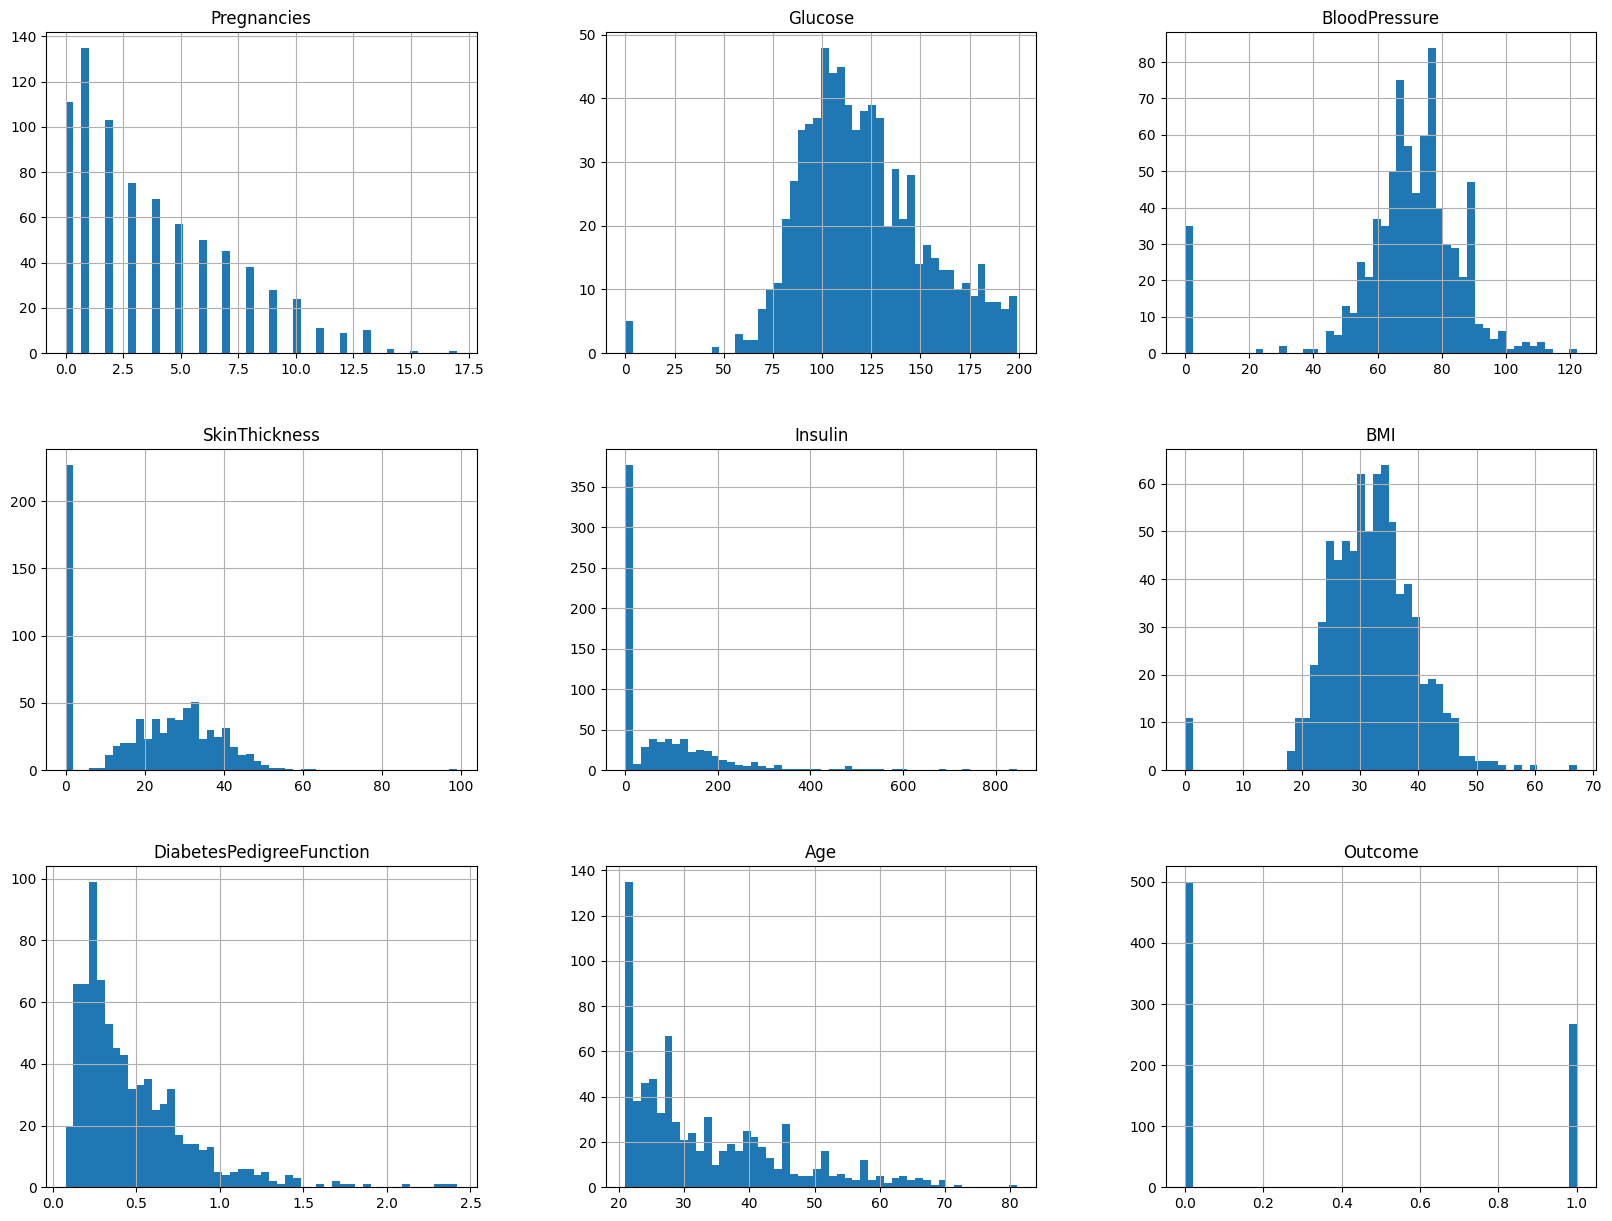

In [5]:
df.hist(bins=50, figsize=(20,15))
plt.show()

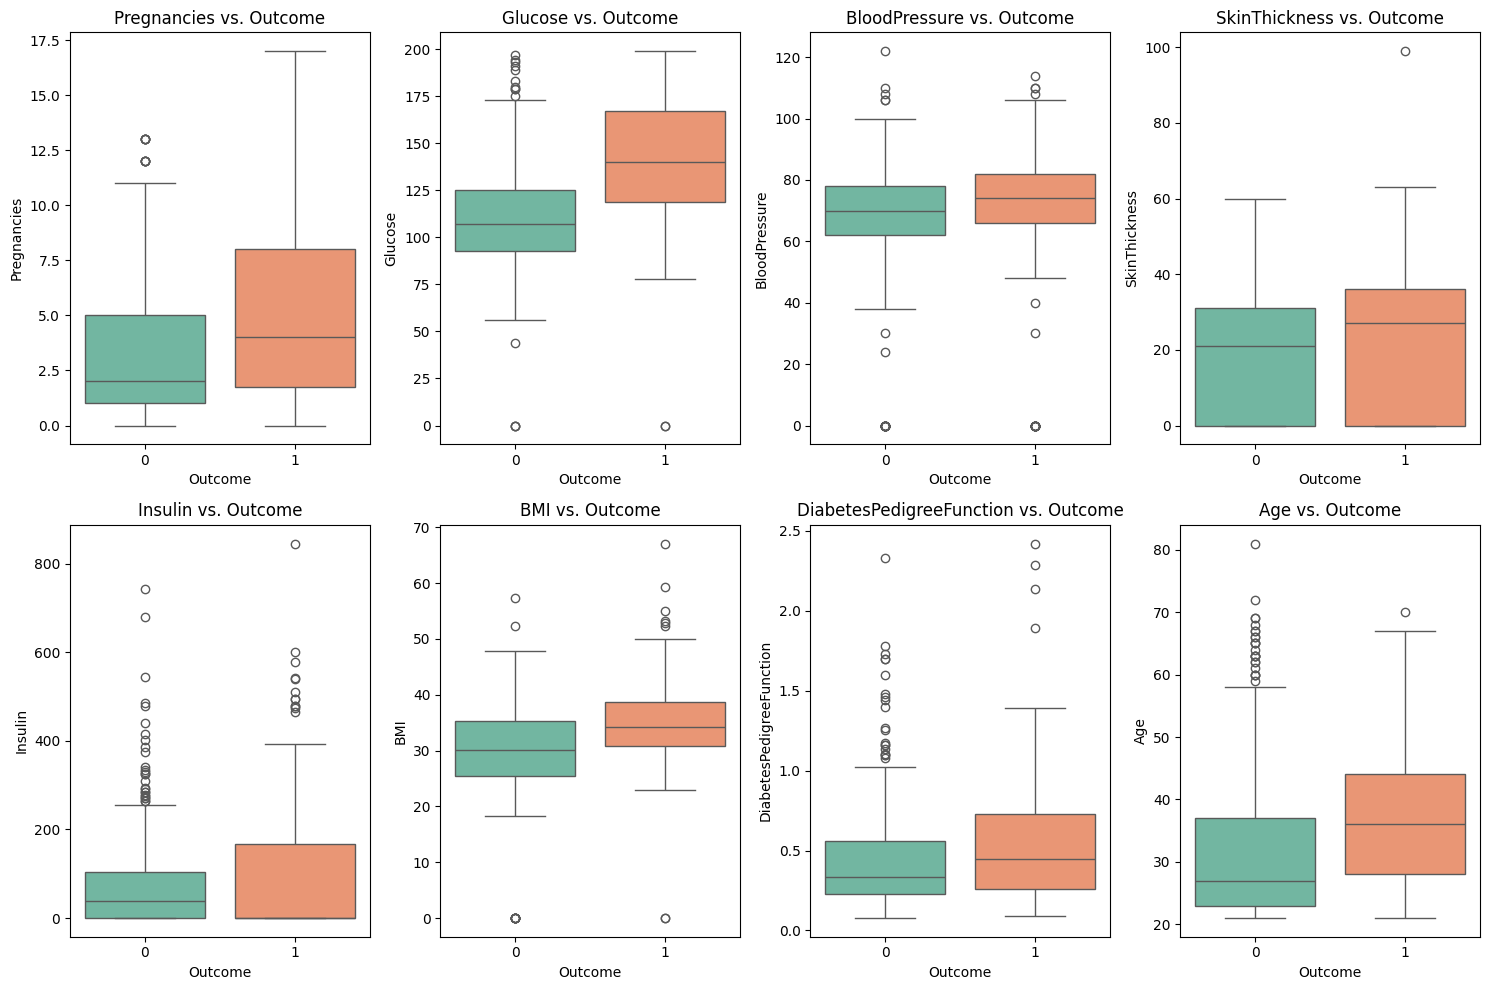

In [6]:
plt.figure(figsize=(15, 10))

for i, column in enumerate(df.columns[:-1]):  # Exclude the last column (target)
    plt.subplot(2, 4, i + 1)
    sns.boxplot(x='Outcome', y=column, data=df, palette='Set2')
    plt.title(f'{column} vs. Outcome')
    
plt.tight_layout()
plt.show()

## 3. Preprocessing

In [7]:
# Replace outliers with NaN
df_2 = df.copy()
df_2.loc[df_2['Glucose'] == 0, 'Glucose'] = np.nan
df_2.loc[df_2['BloodPressure'] == 0, 'BloodPressure'] = np.nan
df_2.loc[df_2['SkinThickness'] > 80, 'SkinThickness'] = np.nan
df_2.loc[df_2['Insulin'] > 800, 'Insulin'] = np.nan
df_2.loc[df_2['BMI'] == 0, 'BMI'] = np.nan
df_2.loc[df_2['DiabetesPedigreeFunction'] > 2, 'DiabetesPedigreeFunction'] = np.nan
df_2.loc[df_2['Age'] > 80, 'Age'] = np.nan

In [8]:
# Create preprocessing pipeline
preprocessor = Pipeline([('imputer', SimpleImputer(strategy='mean')),
                         ('scaler', StandardScaler())])

# Separate features and target
X = df_2.drop('Outcome', axis=1)
y = df_2['Outcome']

# Split the dataset into training+validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the training set into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Standardize the data
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_val = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

## 4. Model training

In [9]:
# Define the Perceptron model
class Perceptron(nn.Module):
    def __init__(self, input_size):
        super(Perceptron, self).__init__()
        self.fc1 = nn.Linear(input_size, 1)
    
    def forward(self, x):
        return torch.sigmoid(self.fc1(x))

In [10]:
# Instantiate the Perceptron model
input_size = X_train.shape[1]  # Number of features
base_model = Perceptron(input_size)

In [14]:
# Function to calculate accuracy
def calculate_accuracy(y_true, y_pred):
    predicted_classes = (y_pred > 0.5).float()
    accuracy = (predicted_classes == y_true).sum() / y_true.shape[0]
    return accuracy.item()

# Function to train the model
def train_model(model, criterion, optimizer, num_epochs=100, batch_size=32):
    # Split training data into batches
    dataset = torch.utils.data.TensorDataset(X_train, y_train)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        # Training loop
        for batch_X, batch_y in dataloader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Evaluate on training set after the epoch
        model.eval()
        with torch.no_grad():
            # Training metrics
            train_outputs = model(X_train)
            train_loss = criterion(train_outputs, y_train)
            train_losses.append(train_loss.item())
            train_accuracy = calculate_accuracy(y_train, train_outputs)
            train_accuracies.append(train_accuracy)

            # Validation metrics
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
            val_losses.append(val_loss.item())
            val_accuracy = calculate_accuracy(y_val, val_outputs)
            val_accuracies.append(val_accuracy)

        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, '
                  f'Train Accuracy: {train_accuracies[-1]:.4f}, '
                  f'Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}')
    
    return train_losses, val_losses, train_accuracies, val_accuracies

In [16]:
# Set up optimizer and loss function for the base model
base_criterion = nn.BCELoss()
base_optimizer = optim.SGD(base_model.parameters(), lr=0.01)

# Train the base model
print("Training Base Model...")
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model=base_model, criterion=base_criterion, optimizer=base_optimizer, num_epochs=50, batch_size=32)

Training Base Model...
Epoch [10/50], Train Loss: 0.4730, Train Accuracy: 0.7739, Val Loss: 0.4719, Val Accuracy: 0.7561
Epoch [20/50], Train Loss: 0.4691, Train Accuracy: 0.7678, Val Loss: 0.4676, Val Accuracy: 0.7561
Epoch [30/50], Train Loss: 0.4663, Train Accuracy: 0.7678, Val Loss: 0.4652, Val Accuracy: 0.7642
Epoch [40/50], Train Loss: 0.4645, Train Accuracy: 0.7699, Val Loss: 0.4636, Val Accuracy: 0.7642
Epoch [50/50], Train Loss: 0.4630, Train Accuracy: 0.7678, Val Loss: 0.4622, Val Accuracy: 0.7886


## 5. Tuning hyperparameters

In [18]:
# Define hyperparameter search space
learning_rates = [0.1, 0.01, 0.001]
num_epochs_list = [50, 200, 500]
batch_sizes = [16, 32, 64]
optimizers = ['SGD', 'Adam', 'RMSprop']

# Run a simple grid search over the hyperparameters and optimizers
best_acc = 0
best_params = {}
best_train_losses = []
best_val_losses = []
best_train_accuracies = []
best_val_accuracies = []

for optimizer_name, lr, epochs, batch_size in product(optimizers, learning_rates, num_epochs_list, batch_sizes):
    print(f"Training with {optimizer_name}, lr={lr}, epochs={epochs}, batch_size={batch_size}")
    
    # Initialize the model, criterion, and optimizer
    model = Perceptron(X_train.shape[1])
    criterion = nn.BCELoss()

    # Choose optimizer based on the current optimizer_name
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=lr)

    # Train and evaluate the model on the validation set
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model, criterion, optimizer, num_epochs=epochs, batch_size=batch_size)
    
    # Track the best performing hyperparameters and optimizer
    if val_accuracies[-1] > best_acc:
        best_acc = val_accuracies[-1]
        best_params = {'optimizer': optimizer_name, 'learning_rate': lr, 'epochs': epochs, 'batch_size': batch_size}
        best_train_losses = train_losses
        best_val_losses = val_losses
        best_train_accuracies = train_accuracies
        best_val_accuracies = val_accuracies
    
    print(f"Validation Accuracy: {val_accuracies[-1]:.4f}")

# Output best results
print(f"Best validation accuracy: {best_acc:.4f} with params {best_params}")

Training with SGD, lr=0.1, epochs=50, batch_size=16
Epoch [10/50], Train Loss: 0.4590, Train Accuracy: 0.7699, Val Loss: 0.4638, Val Accuracy: 0.7805
Epoch [20/50], Train Loss: 0.4585, Train Accuracy: 0.7739, Val Loss: 0.4643, Val Accuracy: 0.7805
Epoch [30/50], Train Loss: 0.4584, Train Accuracy: 0.7699, Val Loss: 0.4651, Val Accuracy: 0.7724
Epoch [40/50], Train Loss: 0.4584, Train Accuracy: 0.7719, Val Loss: 0.4659, Val Accuracy: 0.7724
Epoch [50/50], Train Loss: 0.4586, Train Accuracy: 0.7658, Val Loss: 0.4634, Val Accuracy: 0.7886
Validation Accuracy: 0.7886
Training with SGD, lr=0.1, epochs=50, batch_size=32
Epoch [10/50], Train Loss: 0.4644, Train Accuracy: 0.7597, Val Loss: 0.4600, Val Accuracy: 0.7805
Epoch [20/50], Train Loss: 0.4590, Train Accuracy: 0.7678, Val Loss: 0.4612, Val Accuracy: 0.7805
Epoch [30/50], Train Loss: 0.4585, Train Accuracy: 0.7658, Val Loss: 0.4634, Val Accuracy: 0.7805
Epoch [40/50], Train Loss: 0.4586, Train Accuracy: 0.7719, Val Loss: 0.4613, Val Acc

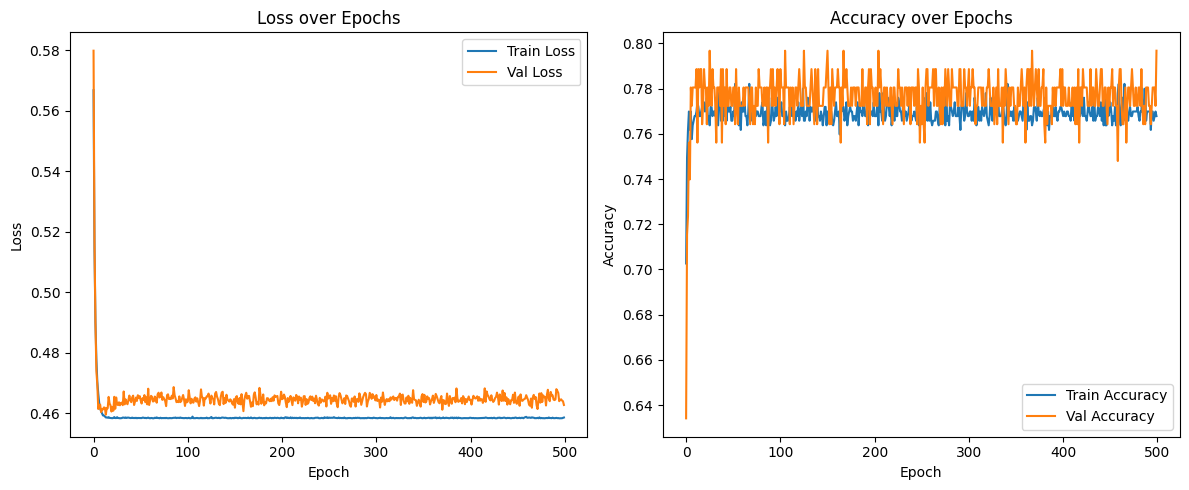

In [19]:
# Plot the training and validation loss and accuracy for the best hyperparameters
plt.figure(figsize=(12, 5))

# Plot Losses
plt.subplot(1, 2, 1)
plt.plot(best_train_losses, label='Train Loss')
plt.plot(best_val_losses, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracies
plt.subplot(1, 2, 2)
plt.plot(best_train_accuracies, label='Train Accuracy')
plt.plot(best_val_accuracies, label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## 6. Evaluate the model

In [20]:
# Final evaluation on the test set after tuning
def evaluate_on_test_set(model):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        predicted_classes = (outputs > 0.5).float()
        accuracy = (predicted_classes == y_test).sum() / y_test.shape[0]
    return accuracy.item()

In [21]:
# Retrain with best hyperparameters on training+validation sets combined
X_train_val_tensor = torch.tensor(preprocessor.fit_transform(X_train_val), dtype=torch.float32)
y_train_val_tensor = torch.tensor(y_train_val, dtype=torch.float32).view(-1, 1)

final_model = Perceptron(X_train_val_tensor.shape[1])

# Select the best optimizer based on tuning
if best_params['optimizer'] == 'SGD':
    final_optimizer = optim.SGD(final_model.parameters(), lr=best_params['learning_rate'])
elif best_params['optimizer'] == 'Adam':
    final_optimizer = optim.Adam(final_model.parameters(), lr=best_params['learning_rate'])
elif best_params['optimizer'] == 'RMSprop':
    final_optimizer = optim.RMSprop(final_model.parameters(), lr=best_params['learning_rate'])

final_criterion = nn.BCELoss()

# Train on the full training+validation set
dataset = torch.utils.data.TensorDataset(X_train_val_tensor, y_train_val_tensor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=best_params['batch_size'], shuffle=True)

for epoch in range(best_params['epochs']):
    final_model.train()
    for batch_X, batch_y in dataloader:
        outputs = final_model(batch_X)
        loss = final_criterion(outputs, batch_y)
        final_optimizer.zero_grad()
        loss.backward()
        final_optimizer.step()

# Evaluate on the test set
test_accuracy = evaluate_on_test_set(final_model)
print(f"Final test accuracy: {test_accuracy:.4f}")

Final test accuracy: 0.7727
